In [25]:
%pip install scipy
import numpy as np 
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter1d, gaussian_filter, gaussian_gradient_magnitude
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.io import imread


Note: you may need to restart the kernel to use updated packages.


### *1.1 Introductory exercise*

This exercise serves to refresh concepts from the basic image analysis curriculum that will be useful at a later stage in the course.

#### *1.1.1 Image convolution*

Image convolution is a central tool in image analysis. In this exercise, you will investigate properties related to convolution using a Gaussian kernel and its derivatives. For further reading material regarding convolution and filtering, refer to [1], Chapter 5. [2]

For continuous functions $f$ and $g$, convolution is defined as

$$
(f * g)(x) = \int_{-\infty}^{\infty} f(x - \tau) g(\tau) d\tau. \tag{1.1}
$$

Convolution is commutative, but we sometimes distinguish between the signal and the kernel, and we say that the signal is convolved with the kernel. In discrete settings, the equation becomes

$$
(f * g)(x) = \sum_{i=-l}^{l} f(x - i) g(i). \tag{1.2}
$$

In 2D, a convolution with a square kernel is given by

$$
(f * g)(x, y) = \sum_{i=-l}^{l} \sum_{j=-l}^{l} f(x - i, y - j) g(i, j). \tag{1.3}
$$

In image analysis, a Gaussian kernel is often used for image smoothing. The 1D Gaussian with variance $t$ is defined by

$$
g(x; t) = \frac{1}{\sqrt{2t\pi}} e^{-\frac{x^2}{2t}}. \tag{1.4}
$$

Sometimes we parametrize the Gaussian with the standard deviation $\sigma$, where $t = \sigma^2$. The 2D isotropic Gaussian is given by

$$
g(x, y; t) = \frac{1}{2t\pi} e^{-\frac{x^2 + y^2}{2t}}. \tag{1.5}
$$



The Gaussian is separable ([3] Section 5.3.1), which means that convolution with two orthogonal 1D Gaussians yields the same result as convolving with a 2D Gaussian of the same variance. This can significantly speed up convolutions, especially for large kernels.

Another property of the Gaussian convolution is the so-called *semi-group structure*, stating that convolving an image $I$ with a single large Gaussian is equivalent to convolving with several small ones:

$$
g(x, y; t_1 + t_2) * I(x, y) = g(x, y; t_1) * g(x, y; t_2) * I(x, y). \tag{1.6}
$$


On the right part of the equation, the order of convolution does not matter, as convolution is associative.

For an image $I$, we often need to know a local change in intensity values. This can be achieved by taking the spatial derivative. Since the image is a discretely sampled signal, we approximate the derivative, often by computing the difference between neighboring pixels.

When taking the derivative, it is often desirable to remove the noise by smoothing, e.g., using a Gaussian. It turns out that instead of convolving with a Gaussian and then taking the derivative, we can convolve with the derivative of the Gaussian:

$$
\frac{\partial}{\partial x} (I * g) = \frac{\partial I}{\partial x} * g = I * \frac{\partial g}{\partial x}. \tag{1.7}
$$


Since we can compute the derivative of the Gaussian analytically, we get an efficient and elegant approach to computing a smoothed image derivative. The analytic expression for the 1D Gaussian derivative is:

$$
\frac{d}{dx} g(x) = \frac{-x}{\sigma^3 \sqrt{2\pi}} e^{-\frac{x^2}{2\sigma^2}} = \frac{-x}{t} g(x). \tag{1.8}
$$


The semi-group structure also holds for image derivatives, such that:

$$
\frac{\partial}{\partial x} g(x, y; t_1 + t_2) * I(x, y) = \frac{\partial}{\partial x} g(x, y; t_1) * (g(x, y; t_2) * I(x, y)). \tag{1.9}
$$

This implies that convolving with a large Gaussian derivative yields the same result as convolving with a smaller Gaussian and a smaller Gaussian derivative.

### *Exercise overview*  
We will experimentally test the statements made in the text above. You may use an existing implementation of convolution, e.g., `scipy.ndimage.convolve`. However, refrain from using an existing implementation of the Gaussian filtering or functions returning the Gaussian kernel and its derivative.

### *Data*  
For this exercise, you may use any grayscale image. We have provided an X-ray CT image of fibres `fibres_xcth.png`, shown in Figure **1.1** and Figure **1.2**.

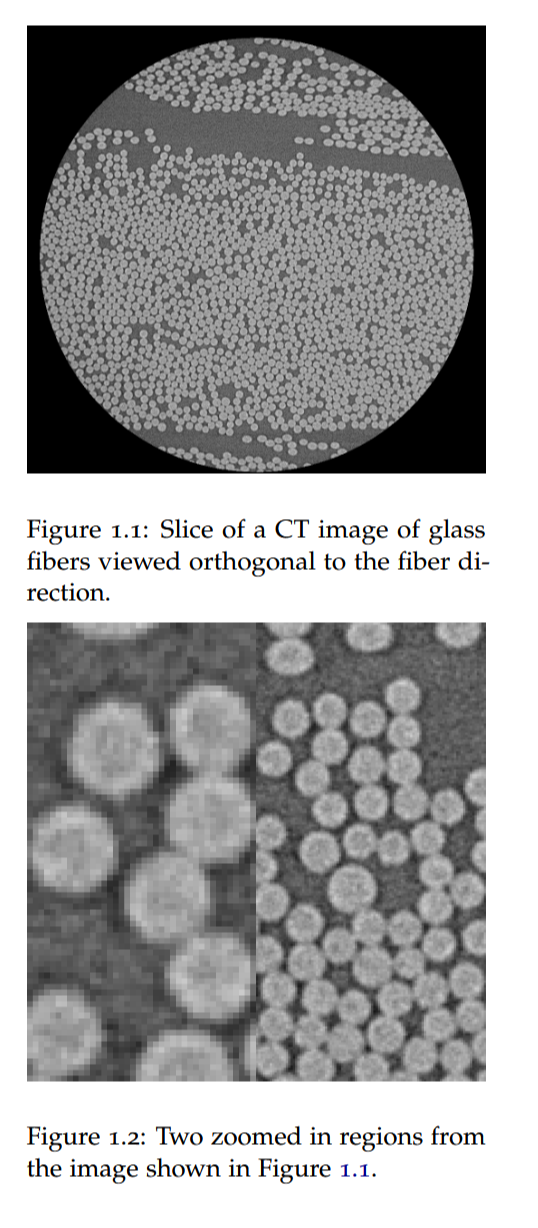


### Tasks

#### 1. **Create Gaussian Kernel**  
   Gaussian kernels are usually truncated at a value between 3 and 5 times $\sigma$. You can create a kernel as follows:

   (a) Compute an integer kernel radius $s$ approximately equal to $4\sigma$.

   (b) Create an array $x$ with integer values centered around 0, that is  
   $x = [-r, \ldots, 0, \ldots, r]$.

   (c) Compute the kernel values using equation 1.4. You may initially compute the values without the normalization term and normalize the kernel to ensure the sum of all values equals 1.

   Verify that your kernel is correct by plotting $x$ against $g$ as shown in **Figure 1.4**. A kernel with the derivative of the Gaussian can be created similarly, and you can see the plot in **Figure 1.5**.


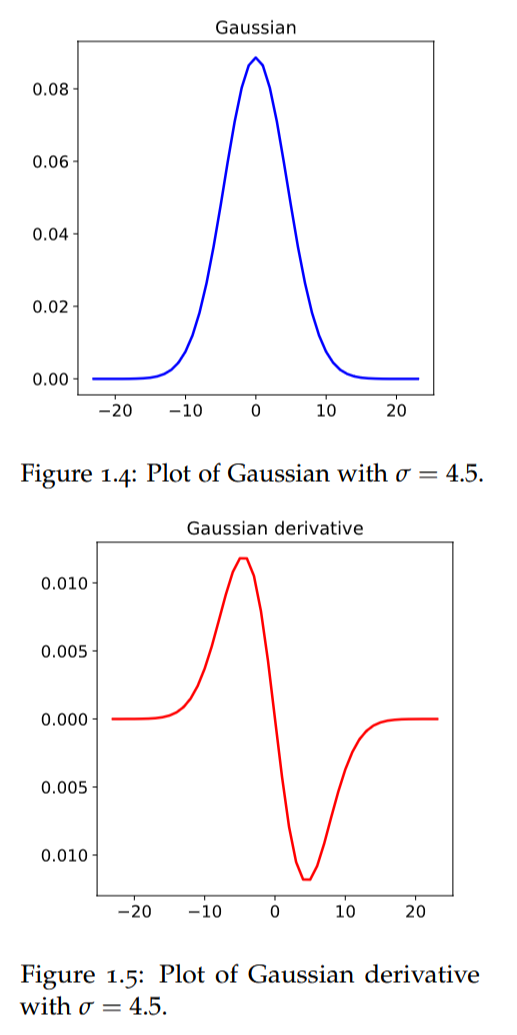


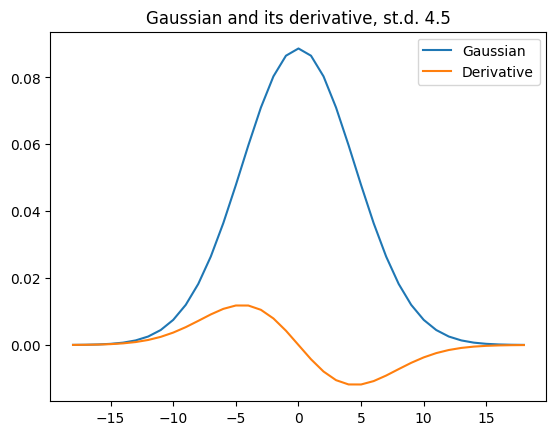

In [26]:
def get_gaussian_kernels(s):
    '''
    Returns a 1D Gaussian kernel and its derivative and the x values.
    
    Parameters
    ----------
    s : float
        Standard deviation of the Gaussian kernel.
        
    Returns
    -------
    g : ndarray
        1D Gaussian kernel.
    dg : ndarray
        Derivative of the Gaussian kernel.
    x : ndarray
        x values where the Gaussian is computed.
    '''
    # Variance of the Gaussian
    t = s**2
    # Range for the kernel: covers ±4 standard deviations
    r = np.ceil(4 * s)
    # x values for the kernel, column vector
    x = np.arange(-r, r + 1).reshape(-1, 1)
    # Compute the Gaussian kernel
    g = np.exp(-x**2 / (2 * t))
    # Normalize the kernel so that its sum is 1
    g = g / np.sum(g)
    # Compute the derivative of the Gaussian kernel
    dg = -x * g / t 
    return g, dg, x

# Set standard deviation for the Gaussian
s = 4.5
# Get the Gaussian kernel, its derivative, and x values
g, dg, x = get_gaussian_kernels(s)

# Create a new figure and axis for plotting
fig, ax = plt.subplots()
# Plot the Gaussian kernel
ax.plot(x, g, label='Gaussian')
# Plot the derivative of the Gaussian kernel
ax.plot(x, dg, label='Derivative')
# Set the plot title
ax.set_title(f'Gaussian and its derivative, st.d. {s}')
# Add a legend to distinguish the curves
ax.legend()
# Display the plot
plt.show()


2. **Experimentally Verify the Separability of the Gaussian Kernel**  
   For this, convolve the test image with a 2D Gaussian kernel. Note that you can get a 2D Gaussian kernel as the *outer product* of two 1D kernels. Then, convolve the same test image with two orthogonal 1D kernels. You should get the same result, i.e., after subtracting the two images, the image difference should be small.  

   **Tip**: Use the `'bwr'` colormap to visualize the difference image. Look at the sketch in **Figure 1.6** to understand what you are testing.

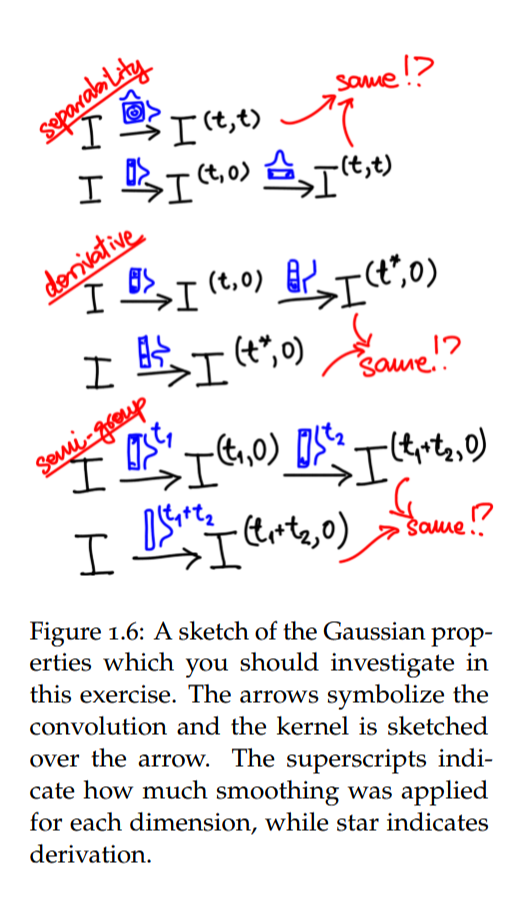

In [34]:
im_dir = 'data/'

im = imread(im_dir + 'fibres_xcth.png').astype(float)

print("Image shape:", im.shape)
print("Image dtype:", im.dtype)
print("Image min:", im.min())
print("Image max:", im.max())

Image shape: (988, 1013)
Image dtype: float64
Image min: 0.0
Image max: 56436.0


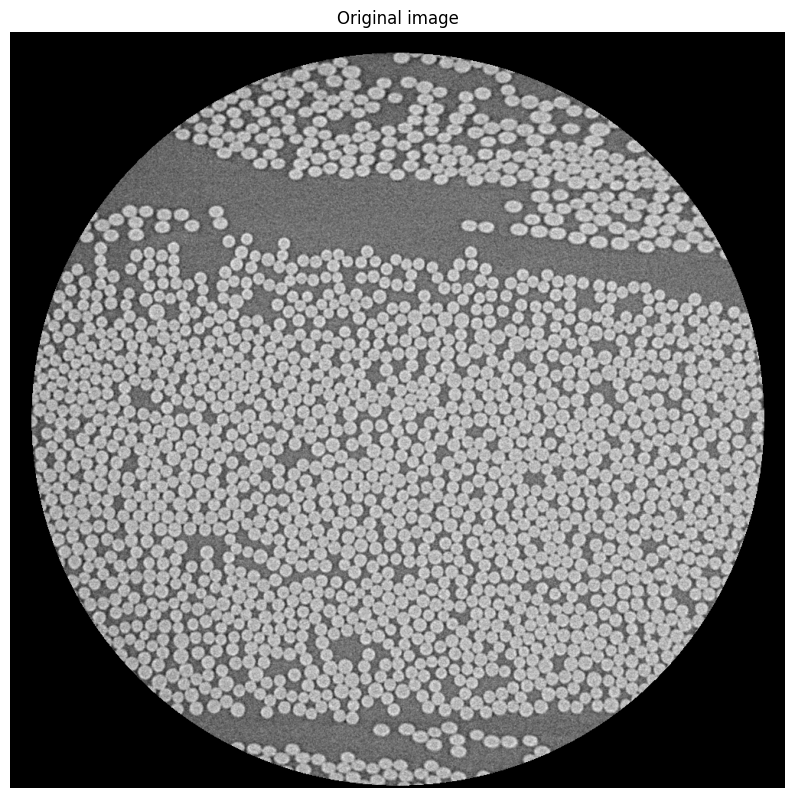

In [31]:
# plot the image 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(im, cmap="gray")
ax.set_title("Original image")
ax.axis("off")
plt.show()


Shape of the 2D kernel: (37, 37)


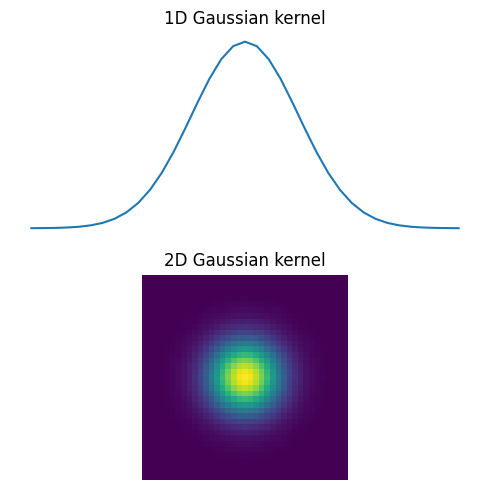

In [35]:
# create 2D kernel by outer product of the 1D kernels
kernel_2d = np.outer(g, g)
print(f"Shape of the 2D kernel: {kernel_2d.shape}")

# visualize the kernel 
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(g, label='1D Gaussian kernel')
ax[0].set_title("1D Gaussian kernel")
ax[0].axis('off')
ax[1].imshow(kernel_2d, cmap='viridis')
ax[1].set_title("2D Gaussian kernel")
ax[1].axis('off')
plt.tight_layout()
plt.show()

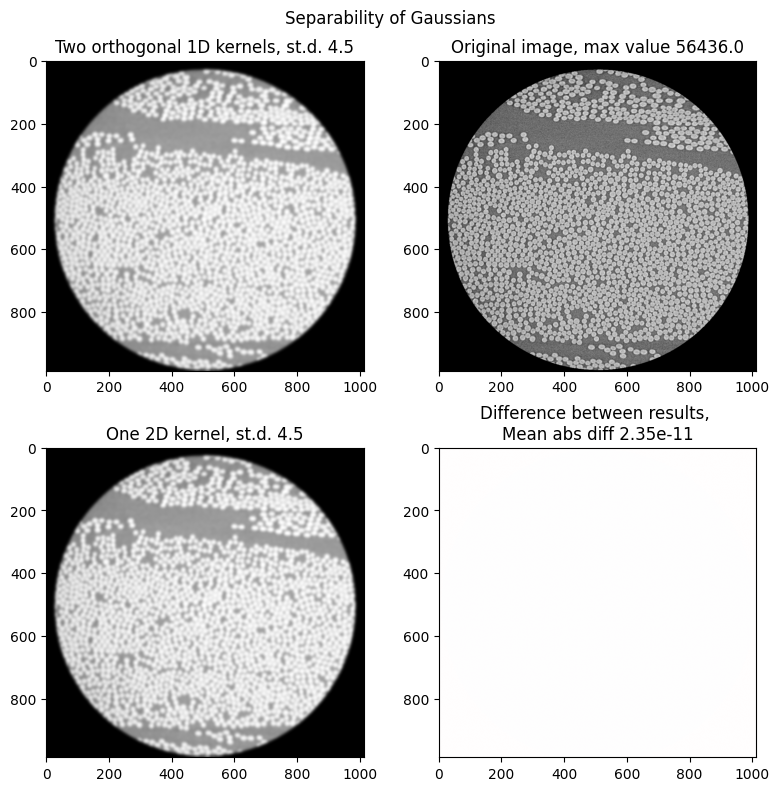

In [38]:
# Create a 2D Gaussian kernel by taking the outer product of the 1D kernel with itself
g2D = g @ g.T 

# Convolve the image with two orthogonal 1D Gaussian kernels:
# First convolve along the rows (or columns), then along the other axis.
# This leverages the separability property of the Gaussian.
im_g = convolve(convolve(im, g), g.T) 

# Convolve the image with the full 2D Gaussian kernel in one step
im_2g = convolve(im, g2D)

# Visualize the results
fig, ax = plt.subplots(2, 2, figsize=(8, 8))    

# Show the result of two 1D convolutions (separable Gaussian)
ax[0][0].imshow(im_g, cmap='gray')
ax[0][0].set_title(f'Two orthogonal 1D kernels, st.d. {s}')

# Show the original image for reference
ax[0][1].imshow(im, cmap='gray')
ax[0][1].set_title(f'Original image, max value {im.max()}')

# Show the result of the 2D convolution
ax[1][0].imshow(im_2g, cmap='gray')
ax[1][0].set_title(f'One 2D kernel, st.d. {s}')

# Show the difference between the two results using a diverging colormap
# The difference should be very small if separability holds
ax[1][1].imshow(im_g - im_2g, cmap='bwr', vmin=-1, vmax=1)
mad = np.abs(im_g - im_2g).mean()  # Mean absolute difference
ax[1][1].set_title(f'Difference between results, \nMean abs diff {mad:0.4g}')

fig.suptitle('Separability of Gaussians')
fig.tight_layout()
plt.show()

3. **Experimentally Verify 1.7**  
   It is enough to test the 1D case. That is, obtain one result by convolving the image with a 1D Gaussian, and take the derivative in the same direction. You can compute the derivative by convolving the image with the kernel $[0.5, 0, -0.5]$.  

   Obtain the second result by convolving the image with the derivative of the Gaussian. Verify that the difference between the two results is small.  

   **Hint**: Compute the average absolute difference between the two images.


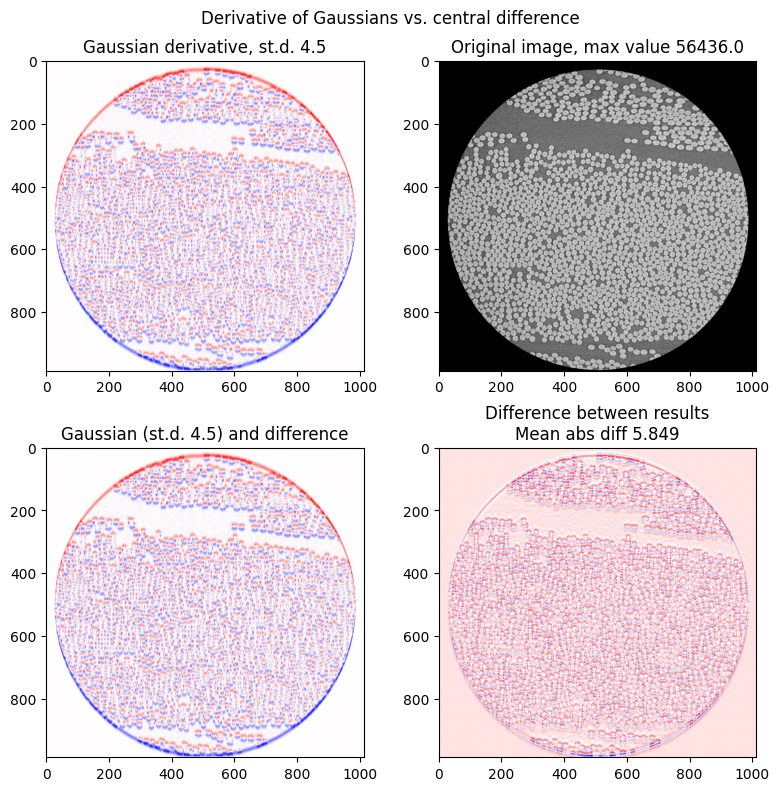

In [41]:
# Convolve the image with the derivative of the Gaussian kernel (dg)
# This computes the smoothed derivative directly, as per equation 1.7
im_gx = convolve(im, dg)

# Define the central difference kernel for numerical derivative: [0.5, 0, -0.5] (vertical orientation)
# This approximates the first derivative in the x-direction
k = np.array([[0.5, 0, -0.5]]).T

# First, smooth the image by convolving with the Gaussian kernel (g)
# Then, compute the derivative by convolving with the central difference kernel (k)
im_dx = convolve(convolve(im, g), k)

# Create a 2x2 grid of subplots for visualization
fig, ax = plt.subplots(2, 2, figsize=(8, 8))    

# Show the result of convolving with the derivative of the Gaussian
ax[0][0].imshow(im_gx, cmap='bwr')
ax[0][0].set_title(f'Gaussian derivative, st.d. {s}')

# Show the original image for reference
ax[0][1].imshow(im, cmap='gray')
ax[0][1].set_title(f'Original image, max value {im.max()}')

# Show the result of smoothing with Gaussian and then applying the central difference
ax[1][0].imshow(im_dx, cmap='bwr')
ax[1][0].set_title(f'Gaussian (st.d. {s}) and difference')

# Show the difference between the two results
# If equation 1.7 holds, this difference should be very small
ax[1][1].imshow(im_gx - im_dx, cmap='bwr')
mad = np.abs(im_gx - im_dx).mean()  # Mean absolute difference
ax[1][1].set_title(f'Difference between results\nMean abs diff {mad:0.4g}')

# Add a super title and adjust layout
fig.suptitle('Derivative of Gaussians vs. central difference')
fig.tight_layout()
plt.show()

4. **Verify that a convolution with a Gaussian of** $t = 20$ **is equal to ten convolutions with a Gaussian of** $t = 2$.  
   Remember that $\sigma = \sqrt{t}$. You can again compare the two images by showing the difference.



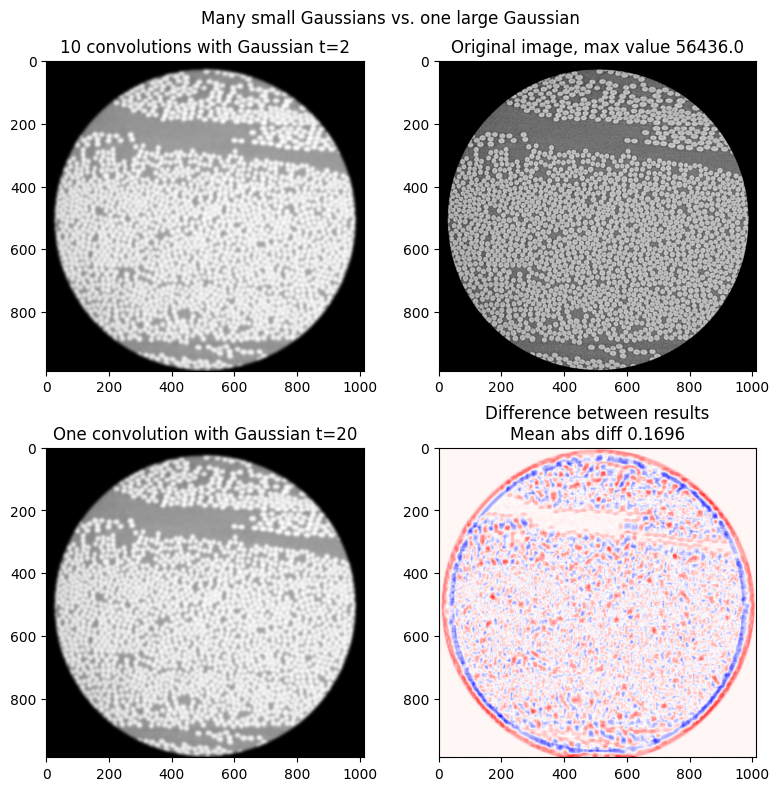

In [42]:
# Set the small Gaussian variance and compute its standard deviation
ts = 2  # small variance
g, dg, x = get_gaussian_kernels(np.sqrt(ts))  # get 1D Gaussian kernel for t=2

# Apply the small Gaussian kernel N times (N=10) to the image
im_gs = im.copy()  # start with the original image
N = 10
for i in range(N):
    # Convolve along rows, then columns (separable 2D convolution)
    im_gs = convolve(convolve(im_gs, g), g.T)

# Set the large Gaussian variance and compute its standard deviation
tl = 20  # large variance
gl, dgl, xl = get_gaussian_kernels(np.sqrt(tl))  # get 1D Gaussian kernel for t=20

# Apply the large Gaussian kernel once to the image (separable 2D convolution)
im_gl = convolve(convolve(im, gl), gl.T)

# Visualize the results for comparison
fig, ax = plt.subplots(2, 2, figsize=(8, 8))    

# Show the result after 10 convolutions with the small Gaussian
ax[0][0].imshow(im_gs, cmap='gray')
ax[0][0].set_title(f'{N} convolutions with Gaussian t={ts}')

# Show the original image for reference
ax[0][1].imshow(im, cmap='gray')
ax[0][1].set_title(f'Original image, max value {im.max()}')

# Show the result after one convolution with the large Gaussian
ax[1][0].imshow(im_gl, cmap='gray')
ax[1][0].set_title(f'One convolution with Gaussian t={tl}')

# Show the difference between the two results using a diverging colormap
# If the semi-group property holds, this difference should be very small
ax[1][1].imshow(im_gs - im_gl, cmap='bwr')
mad = np.abs(im_gs - im_gl).mean()  # Mean absolute difference
ax[1][1].set_title(f'Difference between results\nMean abs diff {mad:0.4g}')

fig.suptitle('Many small Gaussians vs. one large Gaussian')
fig.tight_layout()
plt.show()

5. **Verify that a convolution with a Gaussian derivative of** $t = 20$ **is equal to convolving with a Gaussian of** $t = 10$ **and a Gaussian derivative of** $t = 10$.

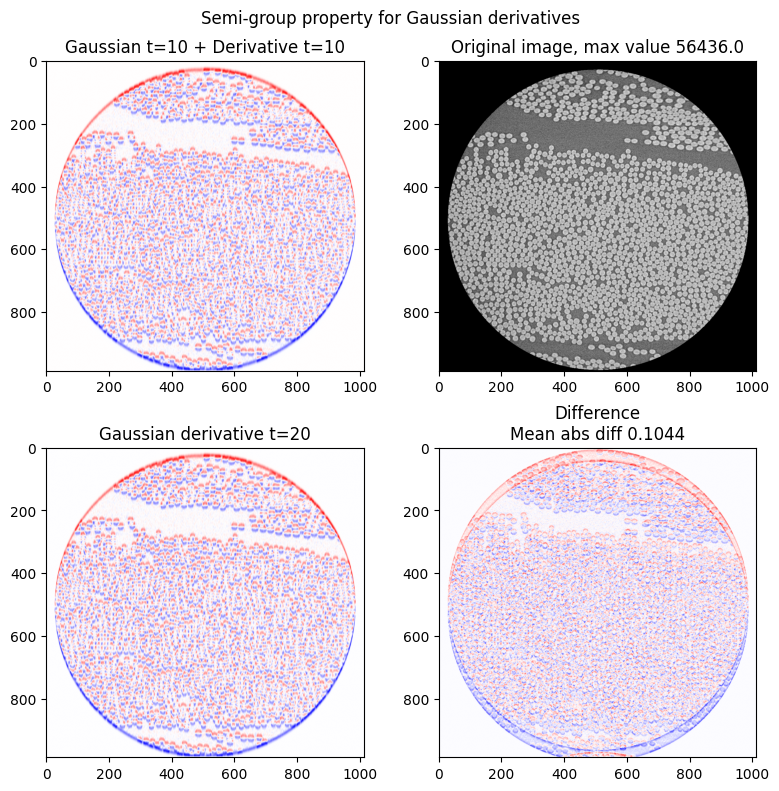

In [46]:
# Verify: Convolution with Gaussian derivative (t=20) == Gaussian (t=10) + Gaussian derivative (t=10)

# 1. Create Gaussian kernel and its derivative for t=10 (sigma = sqrt(10))
ts = 10
g, dg, x = get_gaussian_kernels(np.sqrt(ts))

# 2. Convolve image with Gaussian (t=10) and then with Gaussian derivative (t=10)
#    This is equivalent to smoothing first, then taking the derivative (semi-group property for derivatives)
im_g10_dg10 = convolve(convolve(im, g), dg)

# 3. Create Gaussian derivative kernel for t=20 (sigma = sqrt(20))
tl = 20
gl, dgl, xl = get_gaussian_kernels(np.sqrt(tl))

# 4. Convolve image directly with Gaussian derivative (t=20)
im_dg20 = convolve(im, dgl)

# 5. Visualize and compare the results
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Show result: Gaussian (t=10) + Gaussian derivative (t=10)
ax[0, 0].imshow(im_g10_dg10, cmap='bwr')
ax[0, 0].set_title('Gaussian t=10 + Derivative t=10')

# Show original image for reference
ax[0, 1].imshow(im, cmap='gray')
ax[0, 1].set_title(f'Original image, max value {im.max()}')

# Show result: Gaussian derivative (t=20)
ax[1, 0].imshow(im_dg20, cmap='bwr')
ax[1, 0].set_title('Gaussian derivative t=20')

# Show the difference between the two results
diff = im_g10_dg10 - im_dg20
mad = np.abs(diff).mean()  # Mean absolute difference
ax[1, 1].imshow(diff, cmap='bwr')
ax[1, 1].set_title(f'Difference\nMean abs diff {mad:0.4g}')

fig.suptitle('Semi-group property for Gaussian derivatives')
fig.tight_layout()
plt.show()